# Summary
Model training for Kaggle competition for predicting presence of breast cancer from radiographic images.

## Competition
https://www.kaggle.com/competitions/rsna-breast-cancer-detection

## Inputs
Dicom images pre-converted to smaller PNGs for faster download and training + dicom and patient metadata

| Notebook | Version |
| :-------- | :-----: |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-eda-part-1 | 3 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-eda-part-2 | 2 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-data-prep | 3 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-data-prep-partition | 2 |



# Setup
## Kaggle

In [ ]:
import os
on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None
if on_kaggle:
    !pip install -q neptune-client neptune-fastai

## Imports

In [ ]:
from fastai.vision.all import *
import timm
from sklearn.model_selection import StratifiedGroupKFold

from pathlib import Path
import time

## Check Optimizations
pillow-simd should have a version with a .post? suffix

In [ ]:
import PIL; print(PIL.__version__)

9.4.0


In [ ]:
from PIL import features, Image
from packaging import version

try:    ver = Image.__version__     # PIL >= 7
except: ver = Image.PILLOW_VERSION  # PIL <  7

if version.parse(ver) >= version.parse("5.4.0"):
    if features.check_feature('libjpeg_turbo'):
        print("libjpeg-turbo is on")
    else:
        print("libjpeg-turbo is not on")
else:
    print(f"libjpeg-turbo' status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version {ver}")

libjpeg-turbo is not on


# Config

In [ ]:
neptune_on = True
neptune_project = 'sdhca/rsna-smbcd-2023'

image_path = Path('rsna-smbcd-2023_rescaled-1024')
if on_kaggle:
    image_path = Path('/kaggle/input/rsna-smbcd-2023-data-prep')/image_path

lr_find_on = True

# max_images = 1024  # for debugging. Set to None to use all
max_images = None

## Hyperparameters

In [ ]:
hypp = dict(
    batch_size=32,
    n_epochs=40,
    # nn_arch='mixnet_s',
    # nn_arch='resnet50',
    nn_arch='efficientnet_b3',
    freeze_epochs=2,
    head_lr = 1e-3,
    base_lr = 2e-6,
    approach='Custom fine_tune',
    to_fp16 = True
)

## Neptune

In [ ]:
%load_ext dotenv
if on_kaggle:
    %dotenv /kaggle/input/neptune-dotenv/.env
else:
    %dotenv

In [ ]:
neptune_run = None
if neptune_on:
    import neptune.new as neptune 
    from neptune.new.integrations.fastai import NeptuneCallback
    neptune_run = neptune.init_run(project=neptune_project)
    neptune_run['parameters']=hypp
    neptune_callback = NeptuneCallback(run=neptune_run)
    neptune_run['Notes'] = 'Fit only site 1'

https://app.neptune.ai/sdhca/rsna-smbcd-2023/e/RSNAS-35
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Model Selection

Useful resources:
 * https://timm.fast.ai/
 * https://huggingface.co/docs/timm/results
 * https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
 * https://towardsdatascience.com/does-imagenet-pretraining-work-for-chest-radiography-images-covid-19-2e2d9f5f0875
 * https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055
 
 Let's start with `mixnet_s` for fast iteration because it has only 4 M parameters.

In [ ]:
timm.list_models('mixnet*', pretrained=True)

['mixnet_l', 'mixnet_m', 'mixnet_s', 'mixnet_xl']

In [ ]:
timm.list_models('efficient*', pretrained=True)

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [ ]:
# model = timm.create_model(hypp['nn_arch'], pretrained=True, num_classes=2, in_chans=3)
model, model_cfg = create_timm_model(hypp['nn_arch'], n_out=2, pretrained=True, n_in=3)
model_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth',
 'num_classes': 1000,
 'input_size': (3, 288, 288),
 'pool_size': (9, 9),
 'crop_pct': 1.0,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'test_input_size': (3, 320, 320),
 'architecture': 'efficientnet_b3'}

In [ ]:
img_size = model_cfg['input_size'][1]
img_size

288

In [ ]:
del(model)

# Splits & DataLoaders

In [ ]:
train_df_path = 'train.csv'
if on_kaggle:
    train_df_path = Path('/kaggle/input/rsna-smbcd-2023-zipped-dfs')/train_df_path
train_df = pd.read_csv(train_df_path)
if max_images:
    train_df = train_df.head(n=max_images)
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
train_dcm_df_path = 'train_dcm_df.csv'
if on_kaggle:
    train_dcm_df_path = Path('/kaggle/input/rsna-smbcd-2023-zipped-dfs')/train_dcm_df_path
train_dcm_df = pd.read_csv(train_dcm_df_path, index_col=0)
train_dcm_df.head()

,SOPInstanceUID,ContentDate,ContentTime,PatientID,StudyInstanceUID,SeriesInstanceUID,InstanceNumber,ImageLaterality,SamplesPerPixel,PhotometricInterpretation,...,VOILUTFunction,BodyPartThickness,CompressionForce,ExposureControlMode,ExposureControlModeDescription,MultiPixelSpacing,PixelSpacing,PixelSpacing1,WindowCenter4,WindowWidth4
0,1.2.840.10009.1.2.3.10706.1.763186195,20221118,184026.815884,10706,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1,763186195,L,1,MONOCHROME2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.2.840.10009.1.2.3.10706.1.937109986,20221118,184027.212260,10706,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1,937109986,R,1,MONOCHROME2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.2.840.10009.1.2.3.10706.1.34700621,20221118,184027.020738,10706,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1,34700621,R,1,MONOCHROME2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2.840.10009.1.2.3.10706.1.1167990339,20221118,184026.935329,10706,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1,1167990339,L,1,MONOCHROME2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.2.840.10009.1.2.3.21867.1.1291014447,20221118,184304.095095,21867,1.2.840.10009.1.2.3.21867,1.2.840.10009.1.2.3.21867.1,1291014447,R,1,MONOCHROME1,...,SIGMOID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Site Experiment

In [ ]:
site_counts = pd.value_counts(train_df.site_id)
site_counts

1    29519
2    25187
Name: site_id, dtype: int64

In [ ]:
len(train_df)

54706

In [ ]:
# Model single site
train_df = train_df[train_df.site_id == 2]
len(train_df)

25187

## Train-Test Split by Patient

In [ ]:
patients = train_df[['patient_id', 'cancer']].groupby('patient_id').agg(cancer=('cancer', 'max'), total=('cancer', 'sum'), images=('cancer', 'count'))
patients.describe()

,cancer,total,images
count,6095.000000,6095.000000,6095.000000
mean,0.038392,0.081050,4.132404
std,0.192157,0.412307,0.433680
min,0.000000,0.000000,4.000000
25%,0.000000,0.000000,4.000000
50%,0.000000,0.000000,4.000000
75%,0.000000,0.000000,4.000000
max,1.000000,4.000000,6.000000


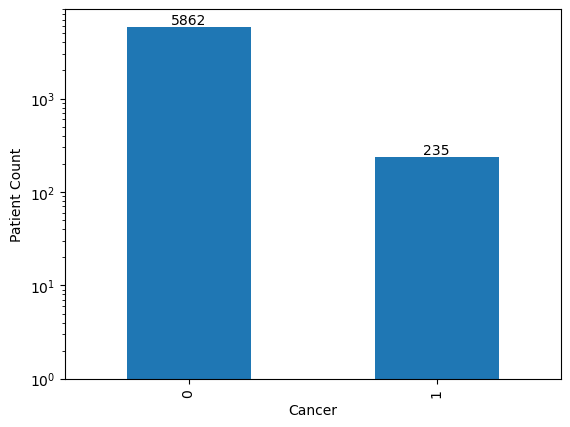

In [ ]:
patient_counts = pd.value_counts(patients['cancer'])
ax = patient_counts.plot.bar(log=True)
# ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[0])
plt.ylabel('Patient Count')
plt.xlabel('Cancer')
plt.show()

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5)
splits = sgkf.split(train_df, train_df.cancer, groups=train_df.patient_id)

for train_index, test_index in splits:
    print(len(train_index), len(test_index), len(train_index) + len(test_index))

20150 5037 25187
20150 5037 25187
20150 5037 25187
20153 5034 25187
20145 5042 25187


With 5 splits, we can just take the last pair of train and test indices to have an 80:20 train:test split.

### Sanity Checks
#### Expected distribution

In [ ]:
train_counts = pd.value_counts(train_df.iloc[train_index]['cancer'])
print(train_counts)
print(train_counts[1] / train_counts[0])

0    19750
1      395
Name: cancer, dtype: int64
0.02


In [ ]:
test_counts = pd.value_counts(train_df.iloc[test_index]['cancer'])
print(test_counts)
try:
    print(test_counts[1] / test_counts[0])
except:
    pass

0    4943
1      99
Name: cancer, dtype: int64
0.020028322880841595


#### No patients in both sets

In [ ]:
train_patients = train_df.iloc[train_index]['patient_id'].unique()
test_patients = train_df.iloc[test_index]['patient_id'].unique()
common_patients = set(train_patients).intersection(set(test_patients))
print(f'# patients common to train and test splits: {len(common_patients)}')

# patients common to train and test splits: 0


## DataBlock

In [ ]:
def _get_image(df, image_path):
    return image_path/'train_images'/f'{df.patient_id}'/f'{df.image_id}.png'

get_image = partial(_get_image, image_path=image_path)

def _get_label(df, label_col):
    return df[label_col]

get_label = partial(_get_label, label_col='cancer')

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    # get_x=lambda x: image_path/'train_images'/f'{x.patient_id}'/f'{x.image_id}.png',
    get_x=get_image,
    get_y=get_label,
    splitter=IndexSplitter(test_index),
    item_tfms=RandomResizedCrop(size=2*img_size, min_scale=1.0),
    batch_tfms=aug_transforms(size=img_size, do_flip=False)
)

In [ ]:
db.summary(train_df)

Setting-up type transforms pipelines
0            2       10006   462822612          L   CC  61.0       0       0   
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
54689        2        9967  1260162631          R   CC  62.0       0       0   
54690        2        9968   766198919          L   CC  76.0       0       0   
54691        2        9968  2098937312          L  MLO  76.0       0       0   
54692        2        9968   294168046          R  MLO  76.0       0       0   
54693        2        9968   568005453          R   CC  76.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0 

## DataLoaders

In [ ]:
class_counts = pd.value_counts(train_df.cancer)
class_wt_dict = dict(1 / class_counts)
class_wt_dict

{0: 4.0497306929089216e-05, 1: 0.0020242914979757085}

In [ ]:
class_wts = train_df.cancer.map(class_wt_dict).values
class_wts

array([4.04973069e-05, 4.04973069e-05, 4.04973069e-05, ...,
       4.04973069e-05, 4.04973069e-05, 4.04973069e-05])

In [ ]:
dls = db.weighted_dataloaders(train_df, bs=hypp['batch_size'], num_workers=8, pin_memory=True, drop_last=True, wgts=class_wts)

In [ ]:
doc(db.dataloaders)

In [ ]:
# With weighting
class_wts = dls

### Show Batch

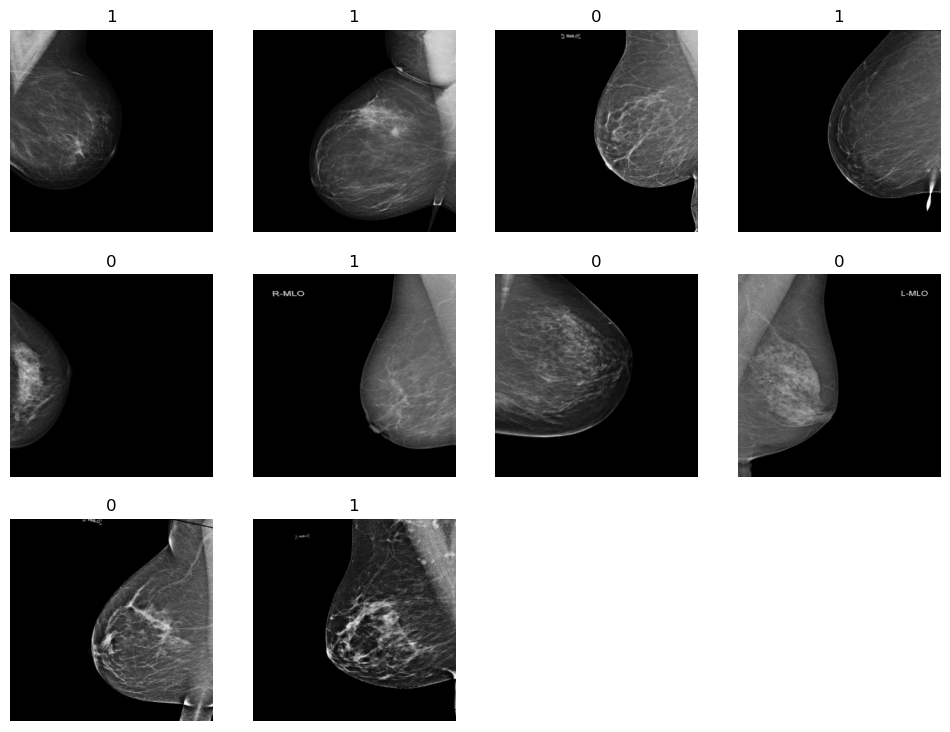

In [ ]:
dls.show_batch(max_n=10)

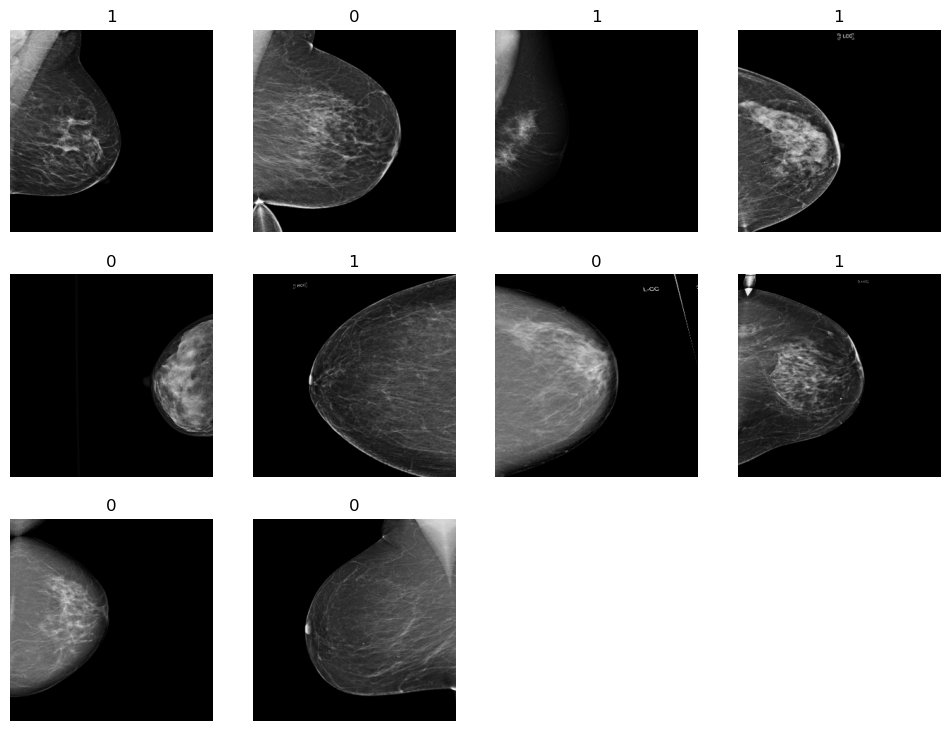

In [ ]:
dls.show_batch(max_n=10)

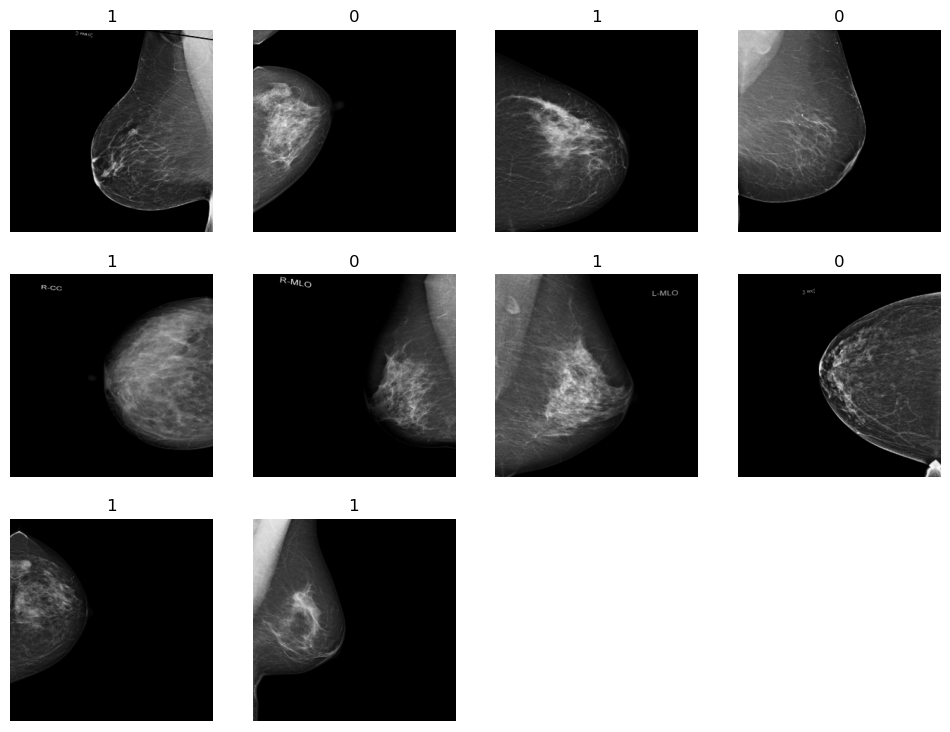

In [ ]:
dls.show_batch(max_n=10)

# Metrics

## Probabilistic F1
https://www.kaggle.com/code/sohier/probabilistic-f-score

In [ ]:
def pfbeta(preds, labels, beta, softmax=None, sigmoid=None):
    # print(f'softmax: {softmax}')
    # print(f'preds: {preds}')
    # print(f'true: {labels}')
    
    probs = preds
    if softmax:
        probs = torch.nn.Softmax(dim=1)(preds)
    elif sigmoid:
        probs = torch.nn.Sigmoid()(preds)
    # print(f'probs: {probs}')
    predictions = probs[:, -1]
    
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    if y_true_count == 0:
        return -1
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0
        
pF1 = partial(pfbeta, beta=1)

# print(pF1([1, 0, 1], [1, 0, 1]))
# print(pF1([0, 1, 0], [1, 0, 1]))
# print(pF1([0.5, 0.5, 0.5], [1, 0, 1]))
# print(pF1([0.5, 0, 0.5], [1, 0, 1]))

In [ ]:
# pF1Score = AccumMetric(pF1, softmax=True, name='pF1', invert_arg=True, to_np=True)
# pF1Score = AccumMetric(pF1, name='pF1', invert_arg=False, to_np=False, flatten=False, softmax=True)  # For CrossEntropyLoss
pF1Score = AccumMetric(pF1, name='pF1', invert_arg=False, to_np=False, flatten=False, sigmoid=True)  # For  BCELoss

## plot_metrics

In [ ]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Train Model

In [ ]:
hypp

{'batch_size': 32,
 'n_epochs': 40,
 'nn_arch': 'efficientnet_b3',
 'freeze_epochs': 2,
 'head_lr': 0.001,
 'base_lr': 2e-06,
 'approach': 'Custom fine_tune',
 'to_fp16': True}

## Create Learner

In [ ]:
# learn = vision_learner(dls, model, metrics=[F1Score(), pF1Score])
# learn = vision_learner(dls, hypp['nn_arch'], metrics=[F1Score(), pF1Score])
learn = vision_learner(dls, hypp['nn_arch'], metrics=[F1Score(), pF1Score, accuracy], n_out=1, loss_func=BCEWithLogitsLossFlat())

if hypp['to_fp16']:
    print('Switching to mixed precision')
    learn = learn.to_fp16()
    
if neptune_on:
    learn.add_cb(neptune_callback)

Switching to mixed precision


In [ ]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [ ]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, MixedPrecision, Recorder, ProgressCallback, NeptuneCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor, MixedPrecision, NeptuneCallback]
         - after_pred     : [MixedPrecision]
         - after_loss     : [MixedPrecision]
         - before_backward: [MixedPrecision]
         - before_step    : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback, NeptuneCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback, NeptuneCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs s

## LR Find - Head

In [ ]:
learn.freeze()

/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/fastai/callback/core.py:60: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` or `repr(object)` instead. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  try: res = getcallable(self, event_name)()


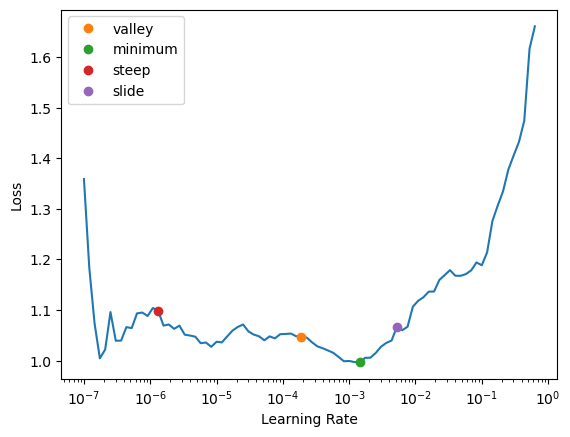

In [ ]:
if lr_find_on:
    learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/fastai/callback/core.py:60: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `String(str(object))` or `String(repr(object))` instead.
  try: res = getcallable(self, event_name)()


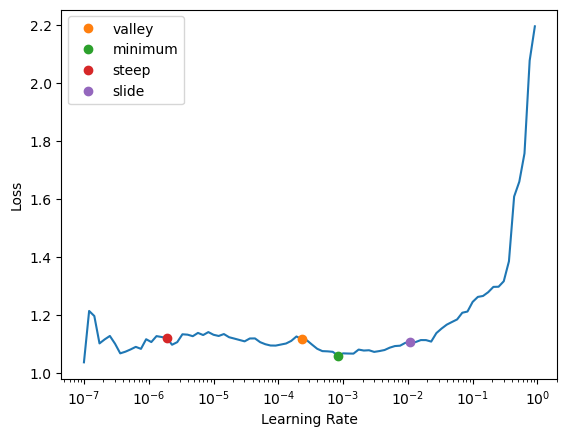

In [ ]:
if lr_find_on:
    learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

## Fine Tune

In [ ]:
# learn.fine_tune(hypp['n_epochs'],
#                 freeze_epochs=hypp['freeze_epochs'], 
#                 base_lr=hypp['base_lr'])

## Fine Tune - Head

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(n_epoch=hypp['freeze_epochs'], lr_max=hypp['head_lr'])

epoch,train_loss,valid_loss,f1_score,pF1,accuracy,time
0,0.650040,0.679726,0.000000,0.041237,0.980365,03:46
1,0.583754,0.548365,0.000000,0.041248,0.980365,03:24


## LR Find - Full

In [ ]:
learn.unfreeze()

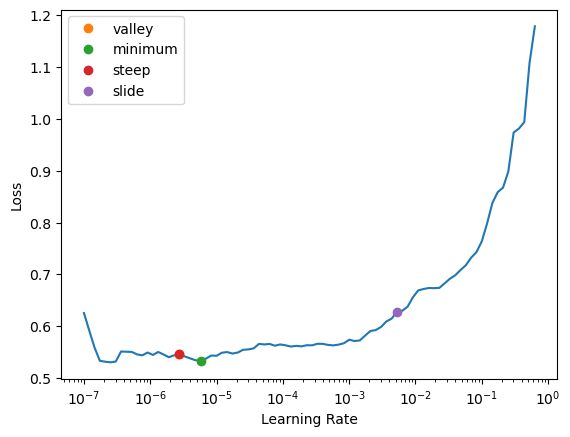

In [ ]:
if lr_find_on:
    learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

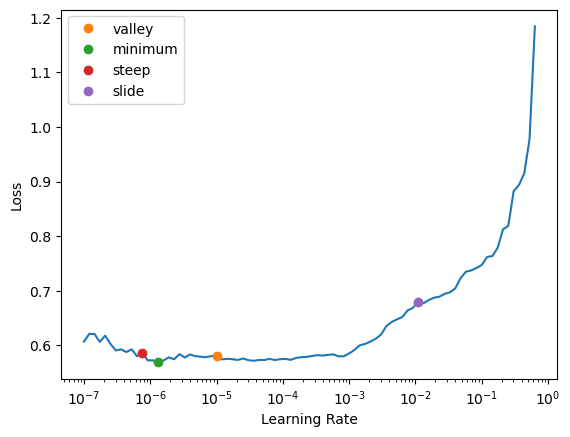

In [ ]:
if lr_find_on:
    learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

## Fine Tune - Full

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(n_epoch=hypp['n_epochs'], lr_max=hypp['base_lr'])

epoch,train_loss,valid_loss,f1_score,pF1,accuracy,time
0,0.580000,0.516708,0.000000,0.042086,0.980365,04:26
1,0.566964,0.548787,0.000000,0.041826,0.980365,04:19
2,0.561293,0.545161,0.000000,0.042316,0.980365,04:16
3,0.565347,0.505974,0.000000,0.042049,0.980365,04:07
4,0.557326,0.545524,0.000000,0.042275,0.980365,04:09
5,0.538310,0.522529,0.000000,0.042028,0.980365,04:13
6,0.535547,0.525900,0.000000,0.042272,0.980365,04:13
7,0.518522,0.498165,0.000000,0.042127,0.980365,04:15
8,0.515153,0.493075,0.000000,0.042111,0.980365,04:15
9,0.496683,0.473077,0.000000,0.043132,0.980365,04:11


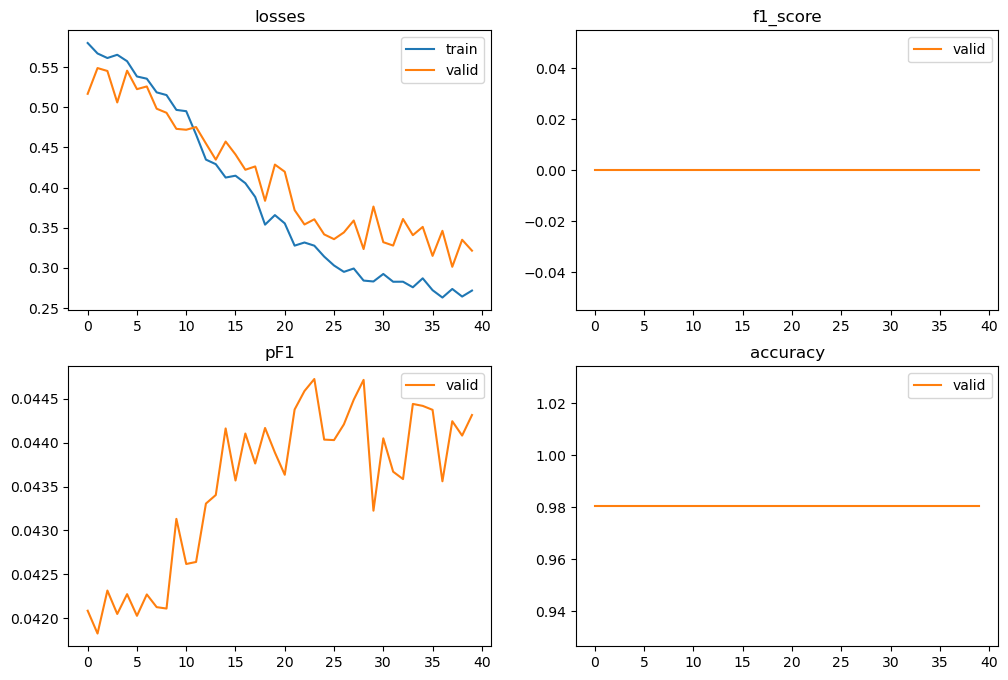

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
if neptune_on:
    neptune_run['final_pf1'] = learn.recorder.metrics[1].value.item()

## Check Results

/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


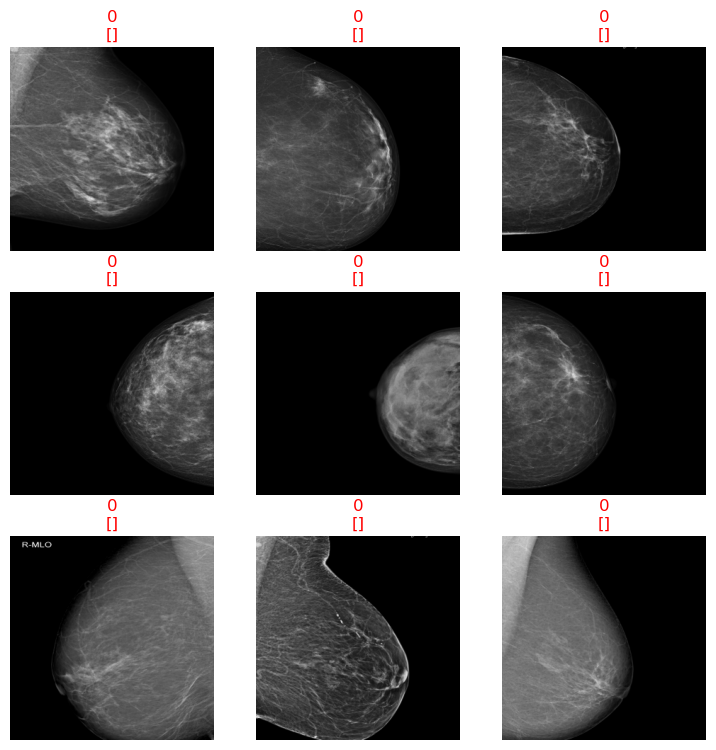

In [ ]:
learn.show_results()

# Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/fastai/callback/core.py:60: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `.log(str(object))` or `.log(stringify_unsupported(collection))` for collections and dictionaries. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  try: res = getcallable(self, event_name)()


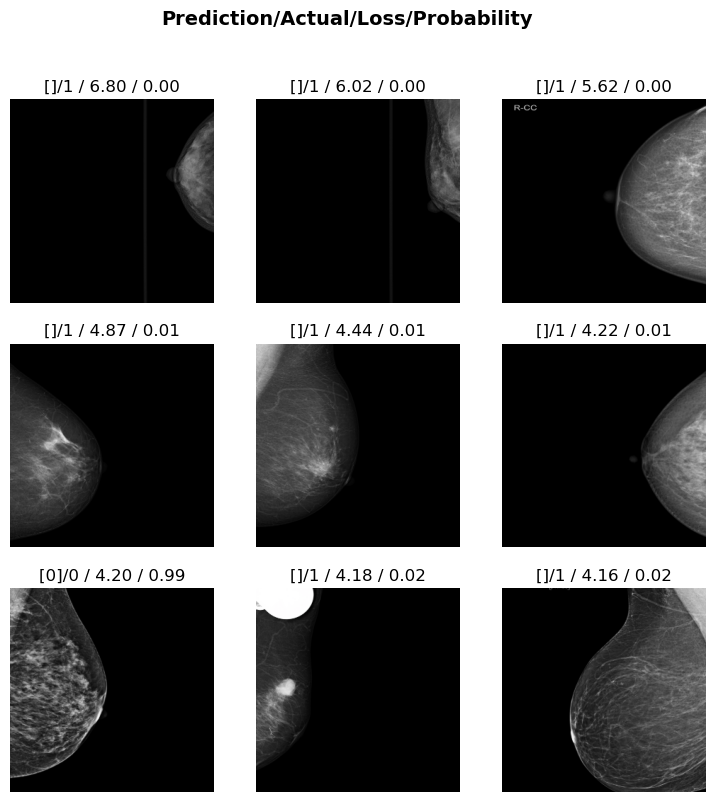

In [ ]:
interp.plot_top_losses(9)

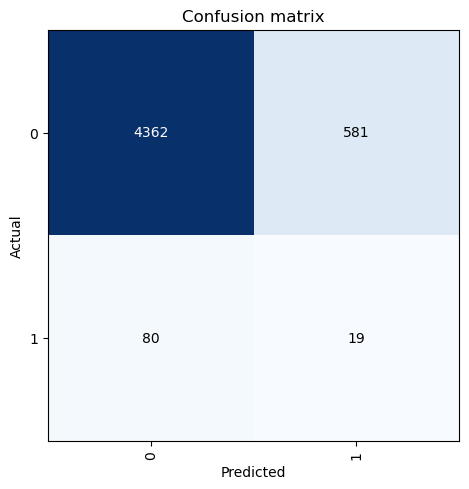

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[(0, 1, 581), (1, 0, 80)]

# Export

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
model_fname = f"rsna-smbcd-2023-{hypp['nn_arch']}-{timestr}.pkl"
if on_kaggle:
    model_fname = Path('/kaggle/working')/model_fname
model_fname

'rsna-smbcd-2023-efficientnet_b3-20230225-124904.pkl'

In [ ]:
if neptune_on:
    neptune_run['model_fname'] = model_fname
    neptune_run.stop()
    learn.remove_cbs(neptune_callback)

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 22 operations to synchronize with Neptune. Do not kill this process.
All 22 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/sdhca/rsna-smbcd-2023/e/RSNAS-35


In [ ]:
learn.export(model_fname)

# Import Test

In [ ]:
test_model = load_learner(model_fname)

In [ ]:
result = test_model.predict(image_path/'train_images/79/1032716115.png')
result

('[]', TensorBase([False]), TensorBase([0.3490]))

In [ ]:
test_model.dls.vocab

[0, 1]

# Todo
1. Choose different learning rates before and after unfreezing the body of the network
2. Label images with bounding boxes and implement segmentation and slicing ideas

# Scratch